In [1]:
import os
os.chdir('../')
from python_code import local_regression
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams.update({'font.size':12})
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Basic code testing

In [2]:
x_data = np.linspace(0,10,100).reshape(-1,1)
x_target = np.linspace(0,10,1000).reshape(-1,1)
y_data = np.cos(3*x_data) + x_data.reshape(-1,1) + np.random.normal(0,.3,size=100).reshape(-1,1)

In [3]:
reg = local_regression.Lowess(degree=2)
reg.fit(x_data, y_data)
y_pred = reg.predict(x_target)

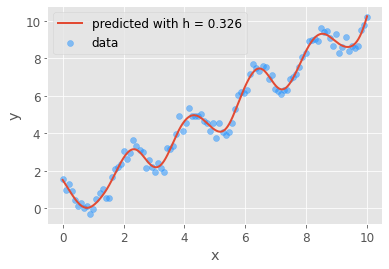

In [4]:
plt.plot(x_target, y_pred, lw=2, label=f'predicted with h = {float(np.round(reg.bandwidth,3))}')
plt.scatter(x_data, y_data, color='dodgerblue', label='data', alpha=.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [6]:
H = reg._calculate_smoothing_matrix(x_target)

In [12]:
H.shape

(1000, 100)

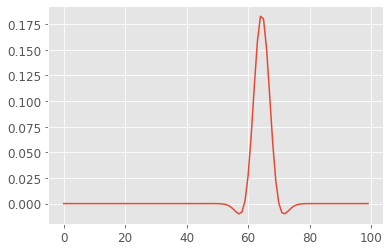

In [15]:
plt.plot(H[650,:]);

## Utilities

In [ ]:
os.getcwd()

In [ ]:
df = pd.read_csv('../data/utilities.csv')

In [ ]:
x = df['temp'].to_numpy().reshape(-1,1)
y =  df['gasbill'].to_numpy().reshape(-1,1)

In [ ]:
x_data.shape

In [ ]:
plt.scatter(x, y)

In [ ]:
scaler.fit(x)

In [ ]:
reg = local_regression.Lowess(degree=2)
reg.fit(x,y)
x_pred = np.linspace(df['temp'].min(), df['temp'].max(), 1000)
y_pred = reg.predict(x_pred)